In [48]:
import pandas as pd
import re
import seaborn as sns
from tqdm import tqdm
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier,DecisionTreeClassifier 
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/anlly/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/anlly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#     <center> HOMEWORK 5   </center>

 ### I. Take the airline opinion dataset (airline_tweets.csv) that was the subject of the Class 12 
 ### II. Divide the dataset into Train/Test: 80/20 percent fix the randomness! 
 ### III. Compare the different Methods:

TextBlob
Microsoft Azure!!!
a train your own model with Sklearn algorithm, compare on the same subset!

In [7]:
URL = "https://raw.githubusercontent.com/mhemmg/datasets/master/nlp/airline_tweets.csv"

airline_tweets = pd.read_csv(URL)
airline_tweets2=airline_tweets[['airline_sentiment','text']]
airline_tweets2.to_csv('full.csv',index=False)
airline_tweets.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


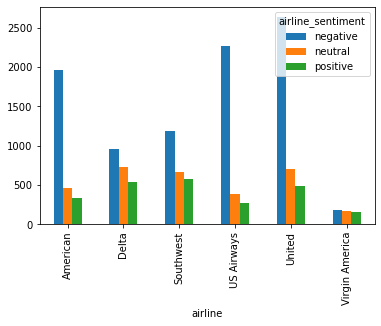

In [42]:
airline_sentiment = airline_tweets.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

In [34]:
clean_tweets = airline_tweets[['airline_sentiment']].copy()

In [35]:
texto = airline_tweets['text'].values
labels = airline_tweets['airline_sentiment'].values

In [36]:
##Limpiando el texto de los tweets
clean_text = []

for i in range(0, len(texto)):
    
    processed_texto = re.sub(r'@\w+', ' ', str(texto[i]))
    processed_texto = re.sub(r'rt @\w+:', ' ', processed_texto)
    processed_texto = re.sub("\d+", ' ', processed_texto)
    processed_texto = re.sub(r'http\S+', ' ', processed_texto)
    processed_texto = re.sub(r'\W', ' ', processed_texto)
    processed_texto= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_texto)
    processed_texto = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_texto) 
    processed_texto = re.sub(r'\s+', ' ', processed_texto, flags=re.I)
    
    processed_texto = processed_texto.lower()
    clean_text.append(processed_texto)

clean_tweets['features']=clean_text

In [37]:
clean_tweets.head(3)

,airline_sentiment,features
0,neutral,what said
1,positive,plus you ve added commercials to the experien...
2,neutral,didn today must mean need to take another trip


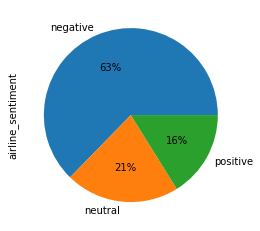

In [41]:
clean_tweets['airline_sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')

Para optimizar el entrenamiento es necesario descartar algunos comentarios que en su mayoría son negativos 

In [45]:
df_tw = clean_tweets.copy()

filter_tw = clean_tweets[clean_tweets['airline_sentiment']=='negative'].index[:6100]
df_tw.drop(index=filter_tw,inplace=True)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df_tw['features'], df_tw['airline_sentiment'], test_size=0.2, random_state=0)

In [53]:
def new_format(X,Y):  #we need to transform the training and test set to fit the classifier format 
    return [(x,y) for x,y in zip(X,Y)]

def divide(data,n):  #the training set is way too large, we need to split it into smaller sets
    m = int(len(data)/n)
    return [data[i*m:(i+1)*m] for i in range(n)]

n_sets = 30
sets = divide(new_format(X_train,y_train),n_sets) 
print('The training set is size {} and was fractioned into {} sets of size {}'.format(len(X_train),n_sets,len(sets[0])))

The training set is size 6832 and was fractioned into 30 sets of size 227


In [52]:
%%time
cl = NaiveBayesClassifier(sets[0])
for i,j in zip(range(10),tqdm(range(10))): #using 15 of the 30 sets for ram memory usage issues when using all sets
  cl.update(sets[i+1])

TB_acc = cl.accuracy(new_format(X_test,y_test))
print('Acuracy \t:',TB_acc)

 90%|███████████████████████████████████████▌    | 9/10 [02:12<00:14, 14.74s/it]


Acuracy 	: 0.7195550351288056
CPU times: user 2min 50s, sys: 3 s, total: 2min 53s
Wall time: 3min


### Sklearn algorithm

In [59]:
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features_vec = vectorizer.fit_transform(clean_text).toarray()

In [64]:
X_train, X_test, y_train, y_test = train_test_split(processed_features_vec, labels, test_size=0.2, random_state=0)

In [63]:
%%time
## Multi Layer Perceptron classifier

from sklearn.neural_network import MLPClassifier
MLP_classifier = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001 )
MLP_classifier.fit(X_train, y_train)

MLP_predictions = MLP_classifier.predict(X_test)
MLP_acc = accuracy_score(y_test, MLP_predictions)

print('Acuracy \t:',MLP_acc)

Acuracy 	: 0.7377049180327869
CPU times: user 3min 21s, sys: 4.45 s, total: 3min 25s
Wall time: 2min 24s


In [67]:
%%time
## random forest

from sklearn.ensemble import RandomForestClassifier
RF_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
RF_classifier.fit(X_train, y_train)

RF_predictions = RF_classifier.predict(X_test)
RF_acc =accuracy_score(y_test, RF_predictions)

print('Acuracy \t:',RF_acc)

Acuracy 	: 0.757172131147541
CPU times: user 1min 44s, sys: 193 ms, total: 1min 44s
Wall time: 1min 47s


In [69]:
%%time
##Linear SVC
from sklearn.svm import LinearSVC

LSVC_classifier = LinearSVC(random_state=0, tol=1e-6)
LSVC_classifier.fit(X_train, y_train)
LSVCpredictions = LSVC_classifier.predict(X_test)
LSVC_acc =accuracy_score(y_test, LSVCpredictions)
print('Acuracy \t:',LSVC_acc)

Acuracy 	: 0.7739071038251366
CPU times: user 439 ms, sys: 16.5 ms, total: 455 ms
Wall time: 1.72 s


In [76]:
texts = [['it wasnt as bad at all'], 
         ['I had real bad trip'],
         ['was a happy trip']]
predictors = [ RF_classifier,
              LSVC_classifier,
              MLP_classifier]
predictors_names = ['Random Forest \t\t\t\t',
                    'Multi Layer Perceptron classifier \t',
                    'Linear support vector classifier \t',
                    'TextBlob Naive Bayes classifier \t']

accuracies = [RF_acc, LSVC_acc, MLP_acc, TB_acc]

In [77]:
for text in texts:
  print('\t')
  print('\t For Text: %s \n' %text[0]) 
  text_v = vectorizer.transform(text).toarray()

  for predictor, name in zip( predictors, predictors_names[:-1]):
    print(name, '...:',predictor.predict(text_v)[0])
  print(predictors_names[-1],'...:',cl.classify(text),'\n')

for acc,name in zip(accuracies,predictors_names):
  print(name,'\t accuracy:' ,acc)

	
	 For Text: it wasnt as bad at all 

Random Forest 				 ...: neutral
Multi Layer Perceptron classifier 	 ...: negative
Linear support vector classifier 	 ...: negative
TextBlob Naive Bayes classifier 	 ...: neutral 

	
	 For Text: I had real bad trip 

Random Forest 				 ...: negative
Multi Layer Perceptron classifier 	 ...: negative
Linear support vector classifier 	 ...: negative
TextBlob Naive Bayes classifier 	 ...: neutral 

	
	 For Text: was a happy trip 

Random Forest 				 ...: negative
Multi Layer Perceptron classifier 	 ...: positive
Linear support vector classifier 	 ...: positive
TextBlob Naive Bayes classifier 	 ...: neutral 

Random Forest 				 	 accuracy: 0.757172131147541
Multi Layer Perceptron classifier 	 	 accuracy: 0.7739071038251366
Linear support vector classifier 	 	 accuracy: 0.7377049180327869
TextBlob Naive Bayes classifier 	 	 accuracy: 0.7195550351288056


Se puede notar que todos los metodos arrojan resultados cercanos, sin embargo, parece que se debe calibrar mejor. Esto se puede hacer variando el set de train y cambiando los parametros de los modelos para obtener un mejor resultado.